# Diabetic Readmittance in the United States

This data was collected over ten years from 1999-2008 across 130 hospitals in the United States. Data from the database meets the following criteria:
   - Inpatient encounter
   - Diabetic encounter
   - Length of stay was betwen 1-14 days
   - Laboratory tests were performed during encounter
   - Medications were admitted during the encounter
   
We will explore the data to understand the most significant tests to run and look the most significant tests to run and factors to look at to prevent readmittance into the hospital for a diabetic encounter after the initial encounter. In our model, we will create a model to predict readmittance in the hopsital based on diagnostic information provided by tests run on patients at the time of their initial admittance.

In [10]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import ensemble
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
import pydotplus
import graphviz
from IPython.display import Image
%matplotlib inline
sns.set_style('white')

In [11]:
data = pd.read_csv('diabetic_data.csv', na_values='?')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
#Check out amount of data that is missing
for col in data.columns:
    print((pd.isnull(data[col])).value_counts())

False    101766
Name: encounter_id, dtype: int64
False    101766
Name: patient_nbr, dtype: int64
False    99493
True      2273
Name: race, dtype: int64
False    101766
Name: gender, dtype: int64
False    101766
Name: age, dtype: int64
True     98569
False     3197
Name: weight, dtype: int64
False    101766
Name: admission_type_id, dtype: int64
False    101766
Name: discharge_disposition_id, dtype: int64
False    101766
Name: admission_source_id, dtype: int64
False    101766
Name: time_in_hospital, dtype: int64
False    61510
True     40256
Name: payer_code, dtype: int64
False    51817
True     49949
Name: medical_specialty, dtype: int64
False    101766
Name: num_lab_procedures, dtype: int64
False    101766
Name: num_procedures, dtype: int64
False    101766
Name: num_medications, dtype: int64
False    101766
Name: number_outpatient, dtype: int64
False    101766
Name: number_emergency, dtype: int64
False    101766
Name: number_inpatient, dtype: int64
False    101745
True         21
Name:

In [13]:
#The weight columns is missing almost all its data, we will drop that
#Two columns are missing around half: payer_code, medical_specialty, seem hospital specific
#We will drop these three rows
data_clean = data.drop(columns=['weight','payer_code','medical_specialty'])

#Also drop values that are simply identifiers
data_clean = data_clean.drop(columns=['encounter_id','patient_nbr','admission_source_id'])

In [14]:
data_clean.head()

,race,gender,age,admission_type_id,discharge_disposition_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,41,0,1,0,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),1,1,3,59,0,18,0,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),1,1,2,11,5,13,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),1,1,2,44,1,16,0,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,1,1,51,0,8,0,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [15]:
#Now dropping na will leave us with 98000 datapoints still
data_clean = data_clean.dropna()
len(data_clean)

98053

In [16]:
#Convert gender to useable binary
data_clean.gender = (data_clean.gender == "Female").astype(int)

#Convert age to useable numbers
def change_age(rang):
    if len(rang) == 6:
        return 5
    return int(rang[1:3])+5

data_clean.age = data_clean.age.apply(change_age)

In [17]:
#Drop Diagnosis code rows with over 700 unique values
data_clean = data_clean.drop(columns=['diag_1','diag_2','diag_3'])

In [18]:
#Convert columns to categorized binaries
data_clean = pd.get_dummies(data_clean, columns=['A1Cresult','max_glu_serum','race', 'metformin',
                                                'repaglinide','nateglinide','chlorpropamide',
                                                'glimepiride','glipizide','glyburide',
                                                'pioglitazone','rosiglitazone','acarbose',
                                                'miglitol','tolazamide','insulin',
                                                'glyburide-metformin'])

#Convert remaining columns to simple binary 0 & 1
data_clean.acetohexamide = (data_clean.acetohexamide == 'Steady').astype(int)
data_clean.tolbutamide = (data_clean.tolbutamide == 'Steady').astype(int)
data_clean.troglitazone = (data_clean.troglitazone == 'Steady').astype(int)
data_clean.examide = (data_clean.examide == 'Steady').astype(int)
data_clean.citoglipton = (data_clean.citoglipton == 'Steady').astype(int)
data_clean['glipizide-metformin'] = (data_clean['glipizide-metformin'] == 'Steady').astype(int)
data_clean['glimepiride-pioglitazone'] = (data_clean['glimepiride-pioglitazone'] 
                                          == 'Steady').astype(int)
data_clean['metformin-rosiglitazone'] = (data_clean['metformin-rosiglitazone'] == 
                                        'Steady').astype(int)
data_clean['metformin-pioglitazone'] = (data_clean['metformin-pioglitazone'] == 
                                        'Steady').astype(int)
data_clean.change = (data_clean.change == 'Ch').astype(int)
data_clean.diabetesMed = (data_clean.diabetesMed == 'Yes').astype(int)
data_clean.readmitted = (data_clean.readmitted != 'NO').astype(int)

In [19]:
#Separating out predictor and outcome variables
X = data_clean.drop(columns=['readmitted'])
y = data_clean.readmitted

In [20]:
#Randomly splitting 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [21]:
#Initial Model Random Forest Classifier
rfc = ensemble.RandomForestClassifier(n_estimators=30, criterion='entropy',
                                      max_depth=10,)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
#Storing CVS values for comparison
rfc_init_cvs = cross_val_score(rfc, X_train, y_train, cv=10)

In [23]:
#Initial Model Decision Tree Classifier
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',max_depth=10)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [24]:
dt_init_cvs = cross_val_score(decision_tree, X_train, y_train, cv=10)

In [25]:
#Initial Model Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
lr_init_cvs = cross_val_score(lr, X_train, y_train, cv=10)

In [27]:
#Initial Model K-Nearest Neighbors
KNN = KNeighborsClassifier(n_neighbors=10)
KNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [28]:
KNN_init_cvs = cross_val_score(KNN, X_train, y_train, cv=10)

In [29]:
#Initial Model Naive Bayes
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [30]:
bnb_init_cvs = cross_val_score(bnb, X_train, y_train, cv=10)

In [31]:
init_models = pd.DataFrame({'RFC': rfc_init_cvs, 
              'DT': dt_init_cvs,
              'LR': lr_init_cvs,
              'KNN': KNN_init_cvs,
              'BNB': bnb_init_cvs})

In [32]:
def get_desc(model):
    for col in model.columns:
        if len(str(col)) == 2:
            print(str(col),' : {0:.3f}'.format(model[col].mean())+'({0:.3f})'.format(
                np.std(model[col])))
        else:
            print(str(col),': {0:.3f}'.format(model[col].mean())+
                  '({0:.3f})'.format(np.std(model[col])))
            
get_desc(init_models)

BNB : 0.607(0.008)
DT  : 0.622(0.007)
KNN : 0.575(0.005)
LR  : 0.615(0.005)
RFC : 0.629(0.005)


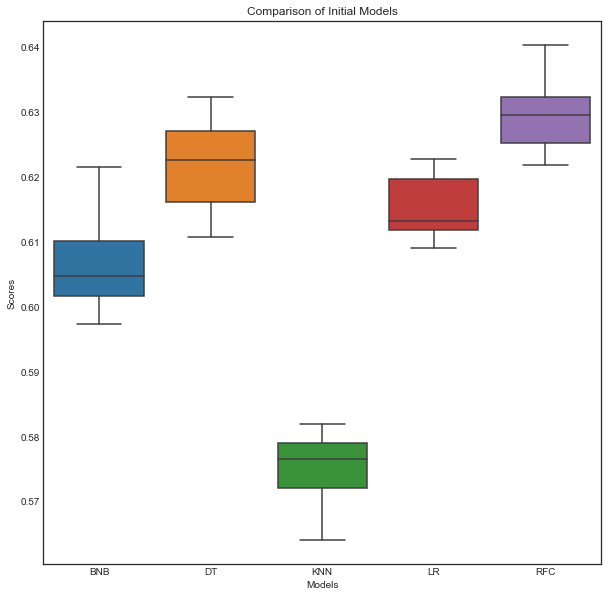

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
im = sns.boxplot(data=init_models, ax=ax)
im.set_title('Comparison of Initial Models')
im.set_ylabel('Scores')
im.set_xlabel('Models')

plt.show()

In [34]:
#Setting parameter dictionary for Gridsearch on RFC to find best combination
parameters = {}
parameters['criterion'] = ['entropy','gini']
parameters['max_depth'] = [10,20,30,40]
parameters['n_estimators'] = [20,40,60,80]

#gsc_rfc = GridSearchCV(rfc, parameters, cv=3, verbose=2)
#gsc_rfc.fit(X_train, y_train)

In [35]:
#print(gsc_rfc.best_params_, gsc_rfc.best_score_)

In [36]:
#Setting parameter dictionary for Gridsearch on BNB to find best combination
parameters_bnb = {}
parameters_bnb['alpha']=[30,40,50,60,70]

#gsc_bnb = GridSearchCV(bnb, parameters_bnb, cv=3, verbose=1)
#gsc_bnb.fit(X_train, y_train)

In [37]:
#print(gsc_bnb.best_params_, gsc_bnb.best_score_)

In [38]:
#Setting parameter dictionary for Gridsearch on DT to find best combination
parameters_dt = {}
parameters_dt['max_depth']=[5,10,20,30]
parameters_dt['criterion']=['gini','entropy']

#gsc_dt = GridSearchCV(decision_tree, parameters_dt, cv=3, verbose=1)
#gsc_dt.fit(X_train, y_train)

In [39]:
#print(gsc_dt.best_params_, gsc_dt.best_score_)

In [40]:
#Setting parameter dictionary for Gridsearch on DT to find best combination
parameters_lr = {}
parameters_lr['C']=[0.009,0.01,0.02,0.03]

#gsc_lr = GridSearchCV(lr, parameters_lr, cv=3, verbose=1)
#gsc_lr.fit(X_train, y_train)

In [41]:
#print(gsc_lr.best_params_, gsc_lr.best_score_)

In [42]:
#Run all models again with optimized parameters, leaving out KNN due to low performance

In [43]:
#Optimized Random Forest
rfc_opt = ensemble.RandomForestClassifier(n_estimators=80, criterion='entropy',
                                      max_depth=10)
rfc_opt.fit(X_train, y_train)
rfc_opt_cvs = cross_val_score(rfc_opt, X_train, y_train, cv=10)

In [44]:
#Optimized Decision Tree
decision_tree_opt = tree.DecisionTreeClassifier(criterion='entropy',max_depth=5)
decision_tree_opt.fit(X_train, y_train)
dt_opt_cvs = cross_val_score(decision_tree_opt, X_train, y_train, cv=10)

In [45]:
#Optimized Bernoulli Naive Bayes
bnb_opt = BernoulliNB(alpha=50)
bnb_opt.fit(X_train, y_train)
bnb_opt_cvs = cross_val_score(bnb_opt, X_train, y_train, cv=10)

In [46]:
#Optimized Logistic Regression
lr_opt = LogisticRegression(C=0.01)
lr_opt.fit(X_train, y_train)
lr_opt_cvs = cross_val_score(lr_opt, X_train, y_train, cv=10)

In [47]:
#Create DataFrame with new optimized data
opt_models = pd.DataFrame({'RFC': rfc_opt_cvs, 
              'DT': dt_opt_cvs,
              'LR': lr_opt_cvs,
              'BNB': bnb_opt_cvs})

In [48]:
get_desc(opt_models)

BNB : 0.607(0.008)
DT  : 0.625(0.007)
LR  : 0.615(0.005)
RFC : 0.631(0.006)


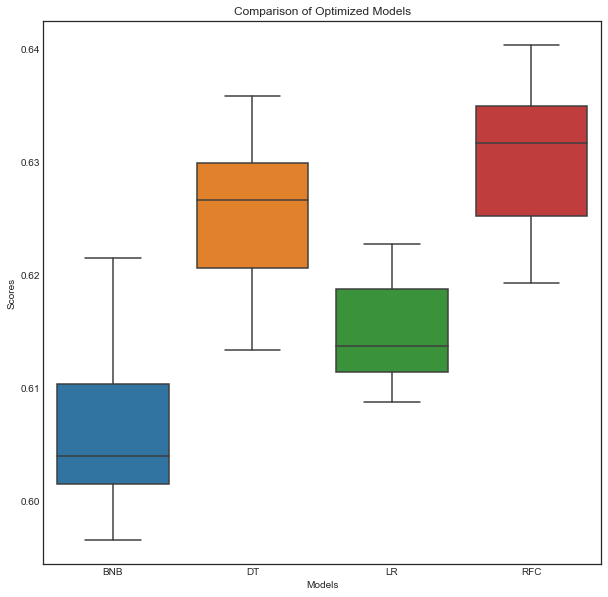

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
im = sns.boxplot(data=opt_models, ax=ax)
im.set_title('Comparison of Optimized Models')
im.set_ylabel('Scores')
im.set_xlabel('Models')

plt.show()

In [50]:
#With the highest correlation, we will use Random Forest Classifier for Feature Selection
#Also keeping Logistic Regression for descriptive information

In [51]:
#Running Recursive Feature Elimination to get ranks of features
rfe = RFECV(rfc_opt, cv=3, verbose=2)
rfe.fit(X_train, y_train)

Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 fe

Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 fe

RFECV(cv=3,
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
   n_jobs=1, scoring=None, step=1, verbose=2)

In [52]:
#Check out which features are estimated to be the best
rfe.ranking_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 65, 54, 62, 66, 69,
       55, 64, 67, 68,  1,  1, 17,  2,  1,  9, 21, 16,  1, 14,  1, 23,  1,
       13, 20, 33,  1,  4, 27, 51, 25, 22, 42, 59, 35, 37, 49, 71, 46, 45,
       58, 39, 19, 24, 38, 34,  3,  8, 29, 30, 11,  7, 28, 44, 10, 15, 40,
       43, 18,  5, 41, 61, 32, 36, 52, 57, 47, 53, 60, 48, 50, 70,  1,  1,
        6, 12, 63, 31, 26, 56])

In [53]:
#Getting rows that correlate to most significant correlation
index = 0
r1_ind = []

for rank in rfe.ranking_:
    if rank == 1:
        r1_ind.append(index)
    index+=1

rank1_columns = X_train.columns[r1_ind]

In [151]:
#Let's take a look at the columns that those #1 ranks correlate to
print(rank1_columns)

Index(['gender', 'age', 'admission_type_id', 'discharge_disposition_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'change', 'diabetesMed',
       'A1Cresult_None', 'max_glu_serum_None', 'race_AfricanAmerican',
       'race_Caucasian', 'metformin_No', 'insulin_Down', 'insulin_No'],
      dtype='object')


In [54]:
#Create new dataset to run RFC and LR on
X_short = X.loc[:, rank1_columns]
X_train2, X_test2, y_train, y_test = train_test_split(X_short,y,test_size=0.2)

In [55]:
#Running Random Forest with reduced dataset
rfc_red = ensemble.RandomForestClassifier(n_estimators=80, criterion='entropy',
                                      max_depth=10)
rfc_red.fit(X_train2, y_train)
rfc_red_cvs = cross_val_score(rfc_red, X_train2, y_train, cv=10)

In [56]:
#Reduced Logistic Regression
lr_red = LogisticRegression(C=0.01)
lr_red.fit(X_train2, y_train)
lr_red_cvs = cross_val_score(lr_red, X_train2, y_train, cv=10)

In [57]:
#Reduced Decision Tree
decision_tree_red = tree.DecisionTreeClassifier(criterion='entropy',max_depth=5)
decision_tree_red.fit(X_train2, y_train)
dt_red_cvs = cross_val_score(decision_tree_red, X_train2, y_train, cv=10)

In [58]:
#Create DataFrame with new reduced data
red_models = pd.DataFrame({'RFC': rfc_red_cvs,
                           'DT': dt_red_cvs,
                            'LR': lr_red_cvs})

In [59]:
get_desc(red_models)

DT  : 0.625(0.005)
LR  : 0.616(0.006)
RFC : 0.632(0.006)


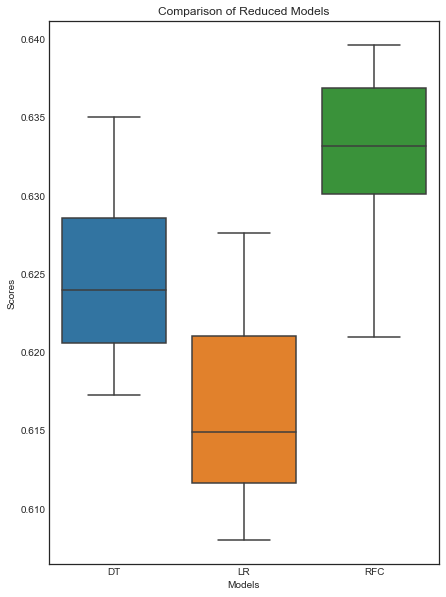

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(7,10)
im = sns.boxplot(data=red_models, ax=ax)
im.set_title('Comparison of Reduced Models')
im.set_ylabel('Scores')
im.set_xlabel('Models')

plt.show()

In [61]:
#Try Boosting Model
gbc = ensemble.GradientBoostingClassifier(loss='deviance', n_estimators=20, max_depth=4
                                         ,subsample=1.0, learning_rate=0.1)
gbc.fit(X_train2, y_train)
gbc_cvs = cross_val_score(gbc, X_train2, y_train, cv=10)

In [62]:
gbc_cvs.mean()

0.6285663381473501

In [63]:
#Setting parameter dictionary for Gridsearch on GBC to find best combination
parameters_gbc = {}
parameters_gbc['loss'] = ['deviance','exponential']
parameters_gbc['n_estimators'] = [5,10,20]
parameters_gbc['max_depth'] = [3,4,5,10]

#gsc_gbc = GridSearchCV(gbc, parameters_gbc, cv=3, verbose=2)
#gsc_gbc.fit(X_train2, y_train)

In [64]:
#print(gsc_gbc.best_params_, gsc_gbc.best_score_)

In [65]:
#Try Boosting Model
gbc_opt = ensemble.GradientBoostingClassifier(loss='exponential', n_estimators=20, 
                                              max_depth=10,subsample=1.0, 
                                              learning_rate=0.1)
gbc_opt.fit(X_train2, y_train)
gbc_opt_cvs = cross_val_score(gbc_opt, X_train2, y_train, cv=10)

In [66]:
#Create separate DataFrame with Boosting Model added in
red_model_wboost = pd.DataFrame({'RFC': rfc_red_cvs,
                                 'DT': dt_red_cvs,
                                 'LR': lr_red_cvs,
                                 'GBC': gbc_opt_cvs})

In [67]:
get_desc(red_model_wboost)

DT  : 0.625(0.005)
GBC : 0.630(0.006)
LR  : 0.616(0.006)
RFC : 0.632(0.006)


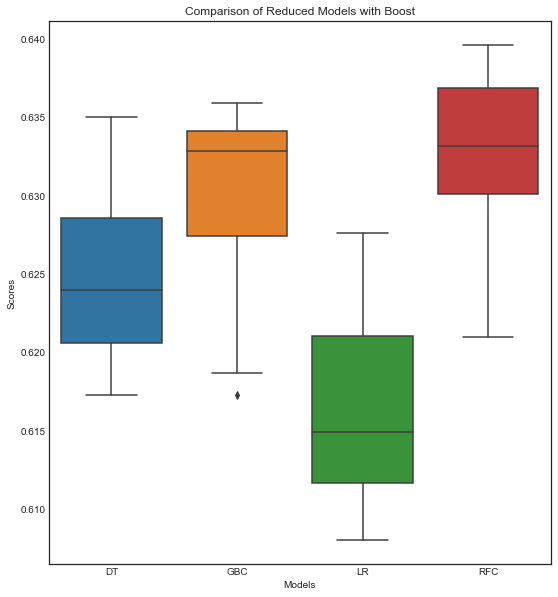

In [68]:
fig, ax = plt.subplots()
fig.set_size_inches(9,10)
im = sns.boxplot(data=red_model_wboost, ax=ax)
im.set_title('Comparison of Reduced Models with Boost')
im.set_ylabel('Scores')
im.set_xlabel('Models')

plt.show()
#fig.savefig('red_model_wboost.png')

In [69]:
#Running Final Random Forest Model
rfc_final = ensemble.RandomForestClassifier(n_estimators=80, criterion='entropy',
                                      max_depth=10)
rfc_final.fit(X_test2, y_test)
rfc_final_cvs = cross_val_score(rfc_final, X_test2, y_test, cv=10)

In [70]:
#Final Boosting Model
gbc_final = ensemble.GradientBoostingClassifier(loss='exponential', n_estimators=20, 
                                              max_depth=10,subsample=1.0, 
                                              learning_rate=0.1)
gbc_final.fit(X_test2, y_test)
gbc_final_cvs = cross_val_score(gbc_final, X_test2, y_test, cv=10)

In [71]:
#Final Decision Tree
dt_final = tree.DecisionTreeClassifier(criterion='entropy',max_depth=5)
dt_final.fit(X_test2, y_test)
dt_final_cvs = cross_val_score(dt_final, X_test2, y_test, cv=10)

In [72]:
#Final Logistic Regression
lr_final = LogisticRegression(C=0.01)
lr_final.fit(X_test2, y_test)
lr_final_cvs = cross_val_score(lr_final, X_test2, y_test, cv=10)

In [73]:
#Create Final DataFrame with Models run on test data
final_model = pd.DataFrame({'RFC': rfc_final_cvs,
                                 'DT': dt_final_cvs,
                                 'LR': lr_final_cvs,
                                 'GBC': gbc_final_cvs})

In [74]:
get_desc(final_model)

DT  : 0.620(0.007)
GBC : 0.618(0.009)
LR  : 0.612(0.008)
RFC : 0.629(0.011)


# Appendix

In [119]:
init_graph_df= init_models.loc[:,['DT','LR','RFC']]

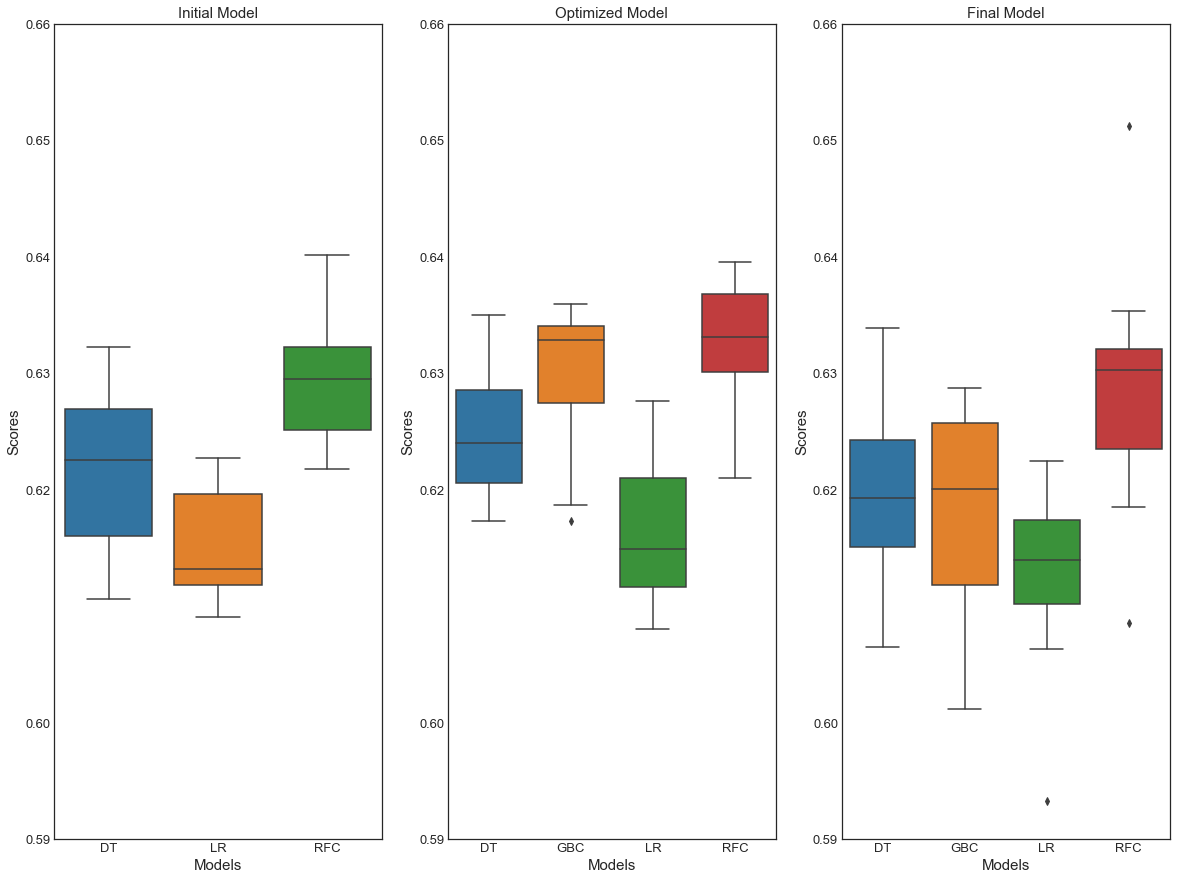

In [147]:
fig = plt.figure(figsize=(20, 15))
#fig.subplots_adjust(hspace=0.5, wspace=0.5)


plt.subplot(1,3,3)
im = sns.boxplot(data=final_model)
im.set_title('Final Model', fontsize=15)
im.set_ylabel('Scores', fontsize=15)
im.set_xlabel('Models', fontsize=15)
plt.yticks([0.59,0.60,0.62,0.63,0.64,0.65,0.66], fontsize=13)
plt.xticks(fontsize=13)


plt.subplot(1,3,2)
im = sns.boxplot(data=red_model_wboost)
im.set_title('Optimized Model', fontsize=15)
im.set_ylabel('Scores', fontsize=15)
im.set_xlabel('Models', fontsize=15)
plt.yticks([0.59,0.60,0.62,0.63,0.64,0.65,0.66],fontsize=13)
plt.xticks(fontsize=13)

plt.subplot(1,3,1)
im = sns.boxplot(data=init_graph_df)
im.set_title('Initial Model', fontsize=15)
im.set_ylabel('Scores', fontsize=15)
im.set_xlabel('Models', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks([0.59,0.60,0.62,0.63,0.64,0.65,0.66], fontsize=13)

plt.show()
fig.savefig('Final_Models.png')

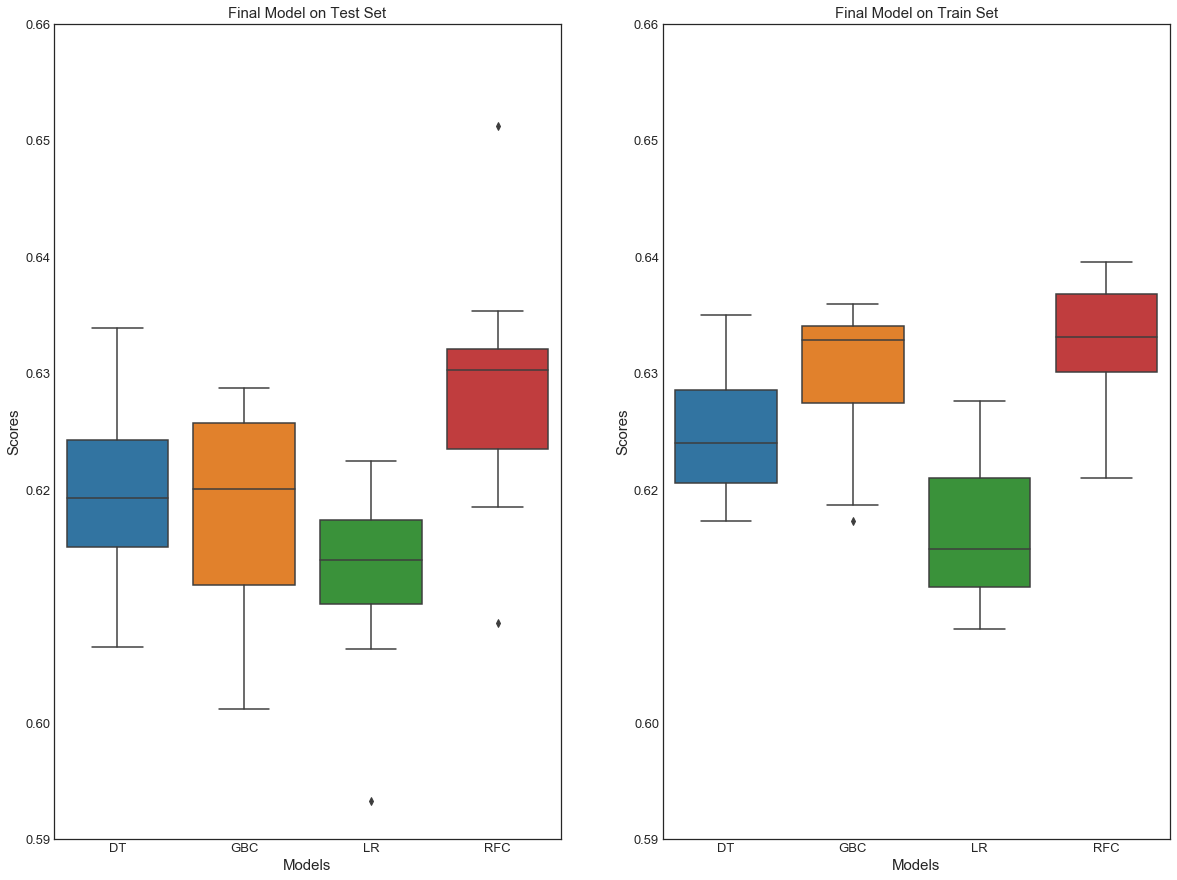

In [150]:
#Final on Test vs Final on Train Datasets
fig = plt.figure(figsize=(20, 15))
#fig.subplots_adjust(hspace=0.5, wspace=0.5)

plt.subplot(1,2,1)
im = sns.boxplot(data=final_model)
im.set_title('Final Model on Test Set', fontsize=15)
im.set_ylabel('Scores', fontsize=15)
im.set_xlabel('Models', fontsize=15)
plt.yticks([0.59,0.60,0.62,0.63,0.64,0.65,0.66], fontsize=13)
plt.xticks(fontsize=13)

plt.subplot(1,2,2)
im = sns.boxplot(data=red_model_wboost)
im.set_title('Final Model on Train Set', fontsize=15)
im.set_ylabel('Scores', fontsize=15)
im.set_xlabel('Models', fontsize=15)
plt.yticks([0.59,0.60,0.62,0.63,0.64,0.65,0.66], fontsize=13)
plt.xticks(fontsize=13)

fig.savefig('TestvTrain_Finalmodel.png')

In [193]:
#Check out coeffcients of cost function - how do each of these things affect the final
#outcome?
#Raise coef to power of e and divide by 1+e^x to get probability of 
#getting y=1 (readmittance)
for i in range(21):
    print(X_short.columns[i],'{0:.2f}'.format((np.e**lr_final.coef_[0][i])/(1+(np.e**lr_final.coef_[0][i]))))

gender 0.52
age 0.50
admission_type_id 0.50
discharge_disposition_id 0.50
time_in_hospital 0.50
num_lab_procedures 0.50
num_procedures 0.49
num_medications 0.50
number_outpatient 0.52
number_emergency 0.54
number_inpatient 0.59
number_diagnoses 0.52
change 0.50
diabetesMed 0.56
A1Cresult_None 0.48
max_glu_serum_None 0.45
race_AfricanAmerican 0.48
race_Caucasian 0.49
metformin_No 0.51
insulin_Down 0.53
insulin_No 0.51


In [204]:
#Checking to see if any medications were ranked high (<=10) in our feature elimination
#Getting rows that correlate to most significant correlation
index5 = 0
r5_ind = []

for rank in rfe.ranking_:
    if rank == 2 or rank == 3or rank == 4 or rank == 5:
        r5_ind.append(index5)
    index5+=1

rank5_columns = X_train.columns[r5_ind]
print(rank5_columns)